In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set 

<function seaborn.rcmod.set>

**Definition: Weiner Process**

A stochastic process $W_t$ is called Winer process if the following conditions hold 

1. $W_o = 0$
2. $W$ has independent increments: 
  - if $r < s< t <u$ then $W_u - W_t$ and $W_s - W_r$ are independent stochatics variables 
3. For $s<t$ the stochastic variable $(W_t-W_s)\sim N(0, \sqrt{t-s}) $


**Ito's formulae**


\begin{align*}
  dS_t  &= \mu_t dt + \sigma_t dW_t \\
  df(t, S_t) &= \Big( \frac{\partial f}{\partial t} + \mu_t \frac{\partial f}{\partial S_t}
    + \frac{\sigma^2_t}{2} \frac{\partial^{2}f}{\partial S_t^2}\Big)dt +  \frac{\partial f}{\partial S_t} \sigma_t dW_t
\end{align*}

- example: 
\begin{align*}
  &dX_t = \mu_t dt + \sigma_t dW_t = \alpha X_t dt + \sigma X_t dW_t \\
  &Z_t = ln(X_t), dZ_t= ? \\
  &\phantom{===}\frac{\partial Z}{\partial t} =0\\
  &\phantom{===}\mu_t \frac{\partial Z}{\partial X} = \alpha \\
  &\phantom{===} \frac{1}{2}\frac{\partial^2 Z}{\partial X^2} \sigma_t = -\frac{1}{2} \sigma^2 \\
  &\phantom{=}\longrightarrow dZ_t = (\alpha - 0.5 \sigma^2)dt + \sigma dW_t
\end{align*}

- $dZ_t = (\alpha - \frac{1}{2} \sigma^2)dt + \sigma dW_t,  Z_i = ln(X_i),  Z_0 = ln(x_0)$

- $Z_t = Z_0 + (\alpha - \frac{1}{2} \sigma^2)dt + \sigma dW_t$

  - $X_t = x_0 \exp \{ (\alpha - \frac{1}{2} \sigma^2)dt + \sigma dW_t\} $
  

- Let S_t be stock price. Then <br>
$\phantom{==}S_{t+1} = S_t \exp \Big\{ (\mu - \frac{1}{2} \sigma^2)dt + \sigma \sqrt{dt}Z_{t+1}\Big\}$


- How to do Monte Carlo simulation?
  1. Generate $m$ independent standard normal variable: $z_1, z_2, \cdots, z_m \sim N(0,1)$
  2. $S_T \triangleq S_0 \exp \Big\{ (\mu - \frac{1}{2} \sigma^2)dt + \sigma \sqrt{dt}z_i\Big\}$ for each $i$
  3. calculate any valuation function (average price, VaR, or option price: $g_i = e^{-rT}F(S_T)$ for each $i$ and present value
    -option example : $g_i = e^{-rT}\Big(S_T - K \Big)^+$
  
  4. $G \approx \frac{1}{m} \sum_{i=1}^{m}g_i$

**Q: How can we simulate the above model(Black-Scholes-Merton setup) in Python?**

In [7]:
rng = np.random.RandomState(123)

In [8]:
T = 2 # years
r = 0.05  # constant short rate
sigma = 0.25  # constant volatility
S0 = 100  # initial value
I = 1000  # number of random draws
M = 50
dt = T / M
S = np.zeros((M + 1, I))
S[0] = S0
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
            + sigma * np.sqrt(dt) * rng.standard_normal(I))

Text(0,0.5,'frequency')

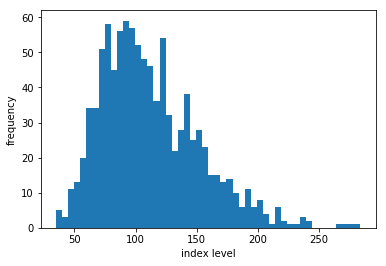

In [15]:
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')

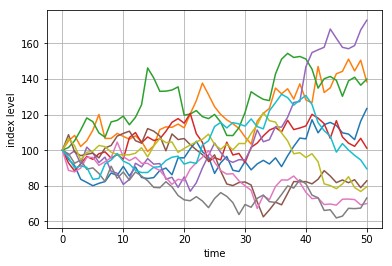

In [13]:
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

# Square root diffusion
- Mean-reverting process
- so called CIR model (Cox-Ingersoll-Roll)
- The below process is $\chi$-distribution process
\begin{align*}
dS_t = -\kappa(\theta-S_t) dt + \sigma \sqrt S_t d\omega_t 
\end{align*}
where $S_t:$price at time $t$,$\kappa$: mean reversion speed ,$\theta$: long run mean of $S_t$, $\sigma$: time invariance volatility, $\omega_t$: standard normal random variable.



**Discretization strategy**
\begin{align*}
S_t = S_b -\kappa (\theta - S_b^+)\Delta t + \sigma \sqrt {S_b^+} \sqrt{\Delta t}\omega_t \\
\end{align*} 

where $b=(t-\Delta t)$ and $S_b^+$=max(0, $S_b$)

In [19]:
rng = np.random.RandomState(123)

In [20]:
x0 = 0.05
kappa = 3.0
theta = 0.02
sigma = 0.1

In [22]:
I = 10000
M = 50
dt = T / M
def srd_euler():
    xh = np.zeros((M + 1, I))
    x1 = np.zeros_like(xh)
    xh[0] = x0
    x1[0] = x0
    for t in range(1, M + 1):
        xh[t] = (xh[t - 1]
              + kappa * (theta - np.maximum(xh[t - 1], 0)) * dt
              + sigma * np.sqrt(np.maximum(xh[t - 1], 0)) * np.sqrt(dt)  
              * rng.standard_normal(I))
    x1 = np.maximum(xh, 0)
    return x1
x1 = srd_euler()

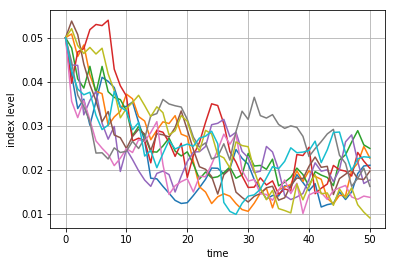

In [23]:
plt.plot(x1[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

**Exact Discretization of CIR model**

\begin{align*}
S_t = \frac{\sigma^2 \left(1-exp(-\kappa \Delta t)\right)}{4\kappa} \chi_d^2 \left( \frac{4\kappa~ exp(-\kappa\Delta t)}{\sigma^2 (1-exp(-\kappa\Delta t)}  S_b\right)
\end{align*}

In [24]:
def srd_exact():
    x2 = np.zeros((M + 1, I))
    x2[0] = x0
    for t in range(1, M + 1):
        df = 4 * theta * kappa / sigma ** 2
        c = (sigma ** 2 * (1 - np.exp(-kappa * dt))) / (4 * kappa)
        nc = np.exp(-kappa * dt) / c * x2[t - 1] 
        x2[t] = c * rng.noncentral_chisquare(df, nc, size=I)
    return x2
x2 = srd_exact()

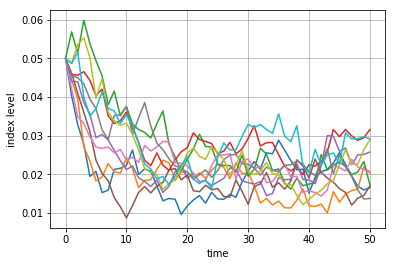

In [25]:
plt.plot(x2[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)
# tag: srd_dt_ex

Later: On demand

- Stochastic volatility model
- Option model